![banniere_one](img/banniere.png)

# Classification Binaire de Pneumonie à partir de Radios Thoraciques

La **pneumonie** est une infection des poumons causée par des bactéries, des virus ou des champignons. Elle entraîne une inflammation des sacs aériens (alvéoles), qui peuvent se remplir de liquide ou de pus, provoquant des symptômes comme la toux, de la fièvre et des difficultés respiratoires.

La pneumonie est une infection pulmonaire sérieuse qui peut être détectée sur des radiographies thoraciques. Ce projet vise à aider les professionnels de santé à accélérer le diagnostic grâce à l’intelligence artificielle.

Dans ce projet, nous entraînons un modèle de deep learning (MobileNetV3Large) pour classifier automatiquement les radiographies thoraciques entre *normal* et *pneumonia*.


Ce notebook présente un projet de classification binaire de pneumonie à partir de radios thoraciques. Nous allons suivre les étapes suivantes :

1. Préparation et exploration du dataset
2. Mise en place du modèle pré-entraîné et adaptation
3. Entraînement du modèle
4. Évaluation du modèle
5. Suivi des expériences via MLflow

## 1 . Préparation et exploration du dataset

### Télécharger le dataset

Nous allons utiliser le dataset Chest X-Ray Pneumonia. Assurez-vous que les images sont organisées dans des sous-dossiers `NORMAL` et `PNEUMONIA` dans le répertoire `data/train`, `data/test`, et `data/val`.

Voici le lien du dataset: 
> [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
- **Licence du dataset :** CC BY 4.0 

## Préparation des dépendances Python et des configurations nécessaires

Dans cette section, nous importons toutes les bibliothèques nécessaires au bon fonctionnement du projet.  
Avant de lancer ce notebook, assurez-vous d’avoir installé les dépendances via la commande suivante :

```bash
pip install -r requirements.txt
``` 

### Pourquoi choisir le modèle MobileNetV3Large ?

j'ai choisi d'utiliser MobileNetV3Large comme base de mon modèle car il s'agit d'un réseau léger et optimisé pour les appareils mobiles, tout en maintenant de bonnes performances sur des tâches de classification d'images. Ce modèle est pré-entraîné sur ImageNet, ce qui permet de bénéficier du transfert d'apprentissage pour accélérer la convergence et améliorer les performances sur des jeux de données de taille modérée comme celui-ci.


In [18]:
# Import des dépendances python nécessaire 

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import random
import subprocess
import requests
import time

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,
                             log_loss, confusion_matrix, classification_report)
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

import mlflow
from mlflow.models.signature import infer_signature

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

### Lancement et vérification de MLflow

Cette fonctionnalité permet de lancer l'interface utilisateur de MLflow sans avoir besoin de le faire manuellement dans votre terminal. Voici quelques points importants à considérer :

1. **Environnement** : Assurez-vous d'être dans votre environnement Python (virtuel ou non) où MLflow est installé.

2. **Démarrage automatique** : Le code vérifie si le serveur MLflow est déjà en cours d'exécution. S'il ne l'est pas, il le démarre automatiquement.

3. **Observation des résultats** : Bien que le serveur MLflow UI puisse être lancé via ce script, il est recommandé de l'exécuter dans votre terminal pour observer les résultats finaux, car le script se termine avec le programme.

4. **Gestion des erreurs** : Le code gère les exceptions lors de la vérification de l'accessibilité du serveur, ce qui permet d'éviter des plantages inattendus.

5. **MLflow Tracking** : Le code configure l'URI de suivi et démarre une nouvelle exécution pour suivre les expériences.

Cette approche garantit que vous pouvez suivre vos expériences de manière efficace tout en ayant la flexibilité de démarrer le serveur MLflow facilement.

In [20]:
# Lancement et vérification MlFlow 

# Vérifier si le serveur MLflow est en cours d'exécution
try:
    response = requests.get("http://localhost:5000")
    response.raise_for_status()  # Cela lèvera une exception si le serveur n'est pas accessible
    print("Le serveur MLflow UI est déjà en cours d'exécution.")
except requests.exceptions.RequestException:
    print("Démarrage du serveur MLflow UI...")
    # Lancer le serveur MLflow UI dans un sous-processus
    subprocess.Popen(["mlflow", "ui"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    # Attendre un peu pour s'assurer que le serveur a le temps de démarrer
    time.sleep(7)

# Vérifier si une exécution est déjà en cours
active_run = mlflow.active_run()
if active_run is not None:
    print(f"Une exécution est déjà en cours : {active_run.info.run_id}. Fin de l'exécution.")
    mlflow.end_run()  # Terminer l'exécution active

# Remplacez par l'ID de l'expérience que vous souhaitez supprimer


# MLflow tracking
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Pneumonia_Classification_MobileNet_V3_Large")
mlflow.start_run()

Le serveur MLflow UI est déjà en cours d'exécution.
Une exécution est déjà en cours : 0c8f0a7e5ba147c5a8ef23b7ba005415. Fin de l'exécution.
🏃 View run agreeable-deer-13 at: http://localhost:5000/#/experiments/335108224053349855/runs/0c8f0a7e5ba147c5a8ef23b7ba005415
🧪 View experiment at: http://localhost:5000/#/experiments/335108224053349855


<ActiveRun: >

## Exploration des données

Commençons par explorer une image du dataset pour vérifier que nous pouvons la lire correctement. Voici les étapes que nous allons suivre :

1. **Chargement de l'image** : Nous chargeons une image depuis un chemin local. L'image est chargée en trois canaux (BGR) avec des valeurs de pixel allant de 0 à 255. Si le chargement échoue, un message d'erreur sera affiché.

2. **Inspection des métadonnées** : Nous affichons les dimensions de l'image et le type de données des valeurs de pixel pour mieux comprendre les caractéristiques de l'image chargée.


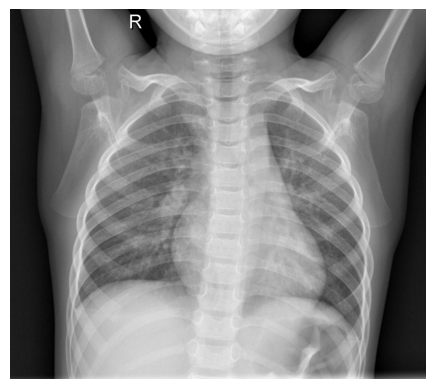

Shape (dimensions)    : (1858, 2090, 3)
Type des valeurs      : uint8


In [3]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/train/NORMAL/IM-0115-0001.jpeg", cv2.IMREAD_COLOR)

# Visualisation de l'image
plt.imshow(img)
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")


### Prétraitement des images

Nous allons transformer nos images pour qu'elles soient conformes à la taille recommandée par notre modèle et en format couleur. Voici les étapes que nous allons suivre :

1. **Chargement des images** : Nous chargeons les images depuis un répertoire structuré en sous-dossiers 'NORMAL' et 'PNEUMONIA'. Chaque image est lue selon le mode spécifié (couleur ou niveaux de gris).

2. **Redimensionnement** : Les images sont redimensionnées à une taille de (224, 224) pixels, qui est la taille d'entrée recommandée pour le modèle MobileNetV3Large.

3. **Normalisation** : Les images seront normalisées plus loin à l'aide de `ImageDataGenerator`, ce qui signifie qu'elles seront converties dans un format lisible pour notre modèle. Cela inclut la mise à l'échelle des valeurs de pixel pour qu'elles soient comprises entre 0 et 1.

4. **Étiquetage** : Les images sont étiquetées avec 0 pour 'NORMAL' et 1 pour 'PNEUMONIA', ce qui facilitera l'entraînement du modèle.

Cette fonction renvoie deux tableaux : un pour les images chargées et redimensionnées, et un autre pour les étiquettes correspondantes.

In [4]:
def load_data(data_dir, img_read_type: int, target_size=(224, 224)):
    """
    Charge les images et les étiquettes depuis un répertoire structuré en sous-dossiers 'NORMAL' et 'PNEUMONIA'.

    Parameters
    ----------
    data_dir : str
        Chemin du dossier contenant deux sous-dossiers : 'NORMAL' et 'PNEUMONIA', chacun contenant les images correspondantes.
    img_read_type : int
        Mode de lecture des images pour OpenCV (par exemple cv2.IMREAD_GRAYSCALE ou cv2.IMREAD_COLOR).
    target_size : tuple (int, int), default=(224, 224)
        Dimensions finales souhaitées pour les images après redimensionnement.

    Returns
    -------
    X : 
        Tableau des images chargées et redimensionnées, converties en float32.
        La forme dépend du mode de lecture (grayscale ou couleur).
    
    y : 
        Tableau des labels (0 pour 'NORMAL', 1 pour 'PNEUMONIA').
    """

    X = []
    y = []
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1}

    for label_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(data_dir, label_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible, on passe
                img = cv2.resize(img, target_size)
                X.append(img)
                y.append(label_map[label_name])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

X_train, y_train = load_data("data/train", cv2.IMREAD_COLOR)
X_test, y_test = load_data("data/test", cv2.IMREAD_COLOR)
X_valid, y_valid= load_data("data/val", cv2.IMREAD_COLOR)

### Création d'un générateur d'images avec normalisation

Dans cette section, nous allons créer un générateur d'images à l'aide de `ImageDataGenerator. Ce générateur appliquera des transformations d'augmentation d'images pour améliorer la robustesse de notre modèle. Voici les étapes que nous allons suivre :

1. **Normalisation** : Nous utiliserons la fonction `preprocess_input` pour normaliser les images selon les exigences du modèle MobileNetV3Large.

2. **Augmentation d'images** : Le générateur appliquera plusieurs transformations aux images d'entraînement, notamment :
   - **Rotation** : Rotation des images jusqu'à 40 degrés.
   - **Translation** : Déplacement horizontal et vertical des images jusqu'à 20 % de leur largeur et hauteur.
   - **Cisaillement** : Application d'une transformation de cisaillement jusqu'à 20 %.
   - **Zoom** : Zoom sur les images jusqu'à 20 %.
   - **Flip horizontal** : Retourner les images horizontalement.
   - **Remplissage** : Utilisation de la méthode de remplissage 'nearest' pour gérer les pixels vides après transformation.

3. **Création des générateurs** : Nous allons créer des générateurs pour les ensembles d'entraînement, de validation et de test à partir des tableaux NumPy contenant les images et les étiquettes. Le générateur d'entraînement appliquera les augmentations, tandis que les générateurs de validation et de test utiliseront les images telles quelles.

Ces générateurs seront utilisés pour alimenter notre modèle lors de l'entraînement et de l'évaluation.


In [5]:
# Créer un générateur d'images avec normalisation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Créer des générateurs à partir des tableaux NumPy
train_generator = datagen.flow(X_train, y_train, batch_size=32)
valid_generator = datagen.flow(X_valid, y_valid, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32,shuffle=False)

### Calcul des poids de classe

Nous allons définir une fonction pour calculer les poids de classe à partir d'un générateur d'images.

Les poids de classe sont utilisés pour compenser les déséquilibres dans les classes lors de l'entraînement d'un modèle. Voici les étapes que nous allons suivre :

1. **Fonction `compute_class_weights`** : Cette fonction prend en entrée un générateur d'images et un nombre de lots à utiliser pour le calcul des poids de classe.

   - **Paramètres** :
     - `generator` : Un objet `ImageDataGenerator` qui produit des lots d'images et d'étiquettes.
     - `num_batches` : Un entier spécifiant le nombre de lots à itérer pour le calcul des poids de classe (par défaut, 10).

   - **Retourne** :
     - Un dictionnaire contenant les poids de classe, où chaque clé correspond à une classe et chaque valeur correspond au poids associé.

2. **Collecte des étiquettes** : La fonction itère sur un nombre spécifié de lots pour collecter les étiquettes. Si le générateur est épuisé avant d'atteindre le nombre de lots spécifié, la boucle se termine.

3. **Calcul des poids de classe** : Les poids de classe sont calculés en utilisant la fonction `compute_class_weight` de `sklearn.utils.class_weight`, qui ajuste les poids en fonction de la fréquence des classes dans les données.

4. **Création d'un dictionnaire de poids** : Un dictionnaire est créé pour associer chaque classe à son poids calculé.

5. **Utilisation de la fonction** : Enfin, nous appelons la fonction `compute_class_weights` en passant le générateur d'entraînement (`train_generator`) pour obtenir les poids de classe.

Faire ce dictionnaire nous permet d'assurer que le modèle ne favorise pas les classes majoritaires lors de l'entraînement, ce qui peut améliorer la performance sur des ensembles de données déséquilibrés.


In [6]:
def compute_class_weights(generator, num_batches=10):
    """
    Calcule les poids de classe pour un ensemble d'étiquettes à partir d'un générateur.

    Parameters
    ----------
    generator : ImageDataGenerator
        Générateur d'images qui produit des lots d'images et d'étiquettes.
    num_batches : int
        Nombre de lots à utiliser pour le calcul des poids de classe.

    Returns
    -------
    dict
        Dictionnaire des poids de classe.
    """
    y = []
    # Limiter le nombre de lots à itérer pour éviter une boucle infinie
    for _ in range(num_batches):
        try:
            _, labels = next(generator)  # Obtenir le prochain lot
            y.extend(labels)
        except StopIteration:
            break  # Sortir si le générateur est épuisé

    y = np.array(y)

    # Calculer les poids de classe
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    
    # Créer un dictionnaire de poids
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    return class_weight_dict

# Calculer les class_weights à partir du train_generator
class_weights = compute_class_weights(train_generator)


Nous allons afficher un échantillon d'images aléatoires provenant de notre générateur d'images (`train_generator`). 
Cela nous permettra de visualiser les données d'entrée et de vérifier que les images sont correctement chargées et étiquetées, cette visualisation nous aide à vérifier que les images sont correctement chargées et étiquetées, ce qui est essentiel pour l'entraînement et l'évaluation de notre modèle.

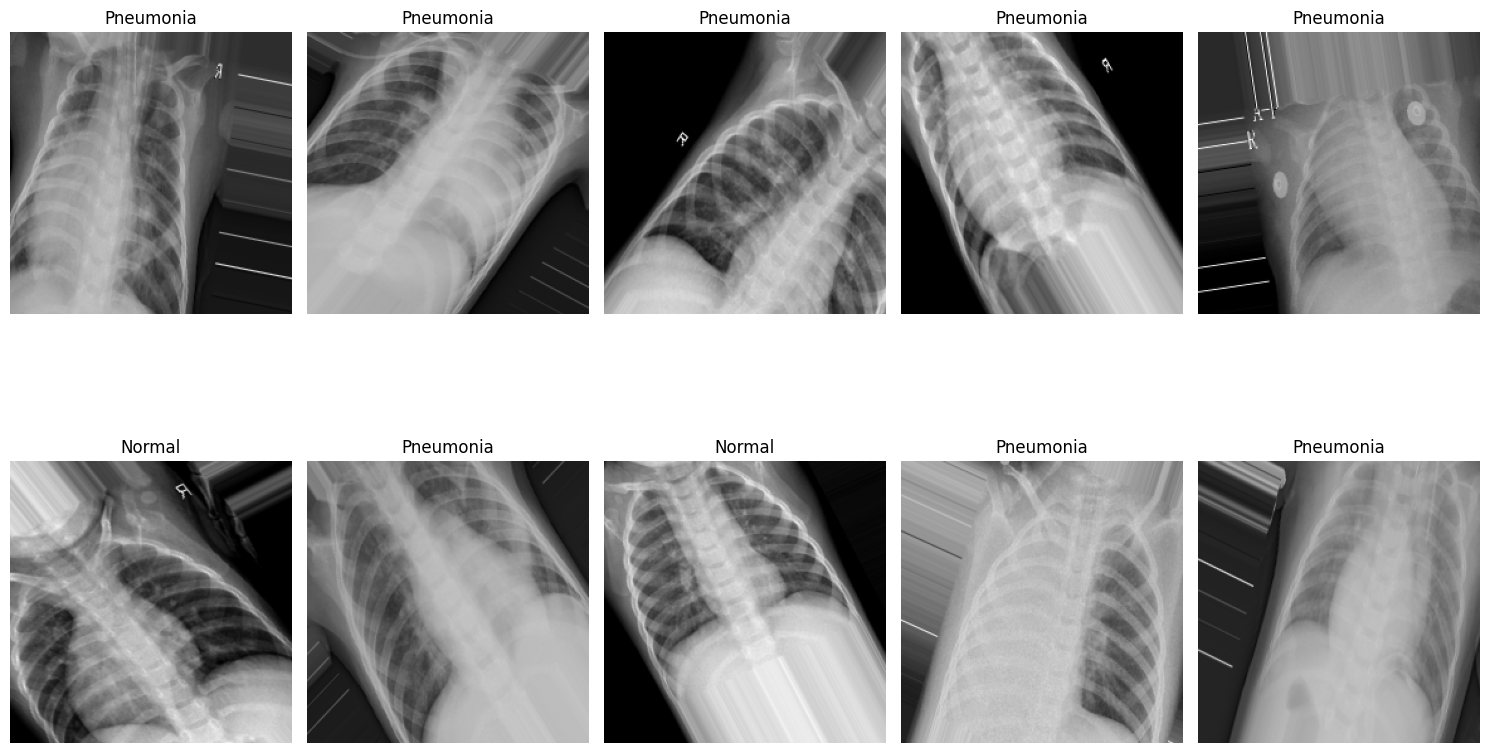

In [7]:
# Test images aléatoires

# Obtenir un lot d'images et d'étiquettes depuis test_generator
images, labels = next(iter(train_generator))

# Mapping des classes
label_name = {0: "Normal", 1: "Pneumonia"}

# Choisir 10 indices aléatoires dans le batch
num_images_to_display = 10
indices = random.sample(range(len(images)), num_images_to_display)

# Créer une figure pour afficher les images
plt.figure(figsize=(15, 10))

# Affichage des images
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)  # 2 lignes, 5 colonnes
    plt.imshow((images[idx] / 255.0).astype(np.float32))  # /255 pour rendre l’image lisible
    plt.title(label_name[labels[idx]])  # Afficher le nom de la classe
    plt.axis("off")

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()


# Entrainement Modèle

### Construction et compilation du modèle MobileNetV3Large

Nous allons construire et compiler un modèle de classification d'images en utilisant l'architecture MobileNetV3Large. Voici les étapes clés :

1. **Chargement du modèle de base** : Nous chargeons MobileNetV3Large sans la couche supérieure (`include_top=False`) et avec des poids pré-entraînés sur ImageNet. La forme d'entrée est définie sur (224, 224, 3), correspondant à la taille des images que nous allons utiliser.

2. **Ajout de couches personnalisées** :
   - **GlobalAveragePooling2D** : Cette couche réduit la dimensionnalité des caractéristiques extraites par le modèle de base en calculant la moyenne de chaque canal.
   - **Dropout** : Une couche de Dropout est ajoutée avec un taux de 30 % pour réduire le risque de surapprentissage.
   - **Dense** : Une couche dense avec une activation sigmoïde est ajoutée pour produire une sortie binaire (0 ou 1).

3. **Création du modèle** : Nous créons un modèle Keras en spécifiant les entrées et les sorties.

4. **Geler les couches du modèle de base** : Pour éviter que les poids du modèle de base ne soient modifiés lors de l'entraînement, nous gelons toutes les couches du modèle de base.

5. **Compilation du modèle** : Nous compilons le modèle en spécifiant l'optimiseur (Adam avec un taux d'apprentissage de 1e-3), la fonction de perte (binary_crossentropy) et les métriques à suivre (accuracy).

6. **Early stopping** : Nous mettons en place un mécanisme d'early stopping pour éviter le surapprentissage. Cela arrêtera l'entraînement si la performance sur l'ensemble de validation ne s'améliore pas pendant 4 époques consécutives, tout en restaurant les meilleurs poids.

Cette approche nous permet de tirer parti des caractéristiques pré-entraînées de MobileNetV3Large tout en ajoutant nos propres couches pour adapter le modèle à notre tâche de classification.

In [8]:
base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
features = base_model.output
features = GlobalAveragePooling2D()(features)
features = Dropout(0.3)(features)
output = Dense(1, activation='sigmoid')(features)

model = Model(inputs=base_model.input, outputs=output)

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping pour éviter l'overfitting
early_stop = EarlyStopping(patience=4, restore_best_weights=True)

### Enregistrement des paramètres et entraînement du modèle

Ensuite, nous allons enregistrer les paramètres du modèle et entraîner le modèle en utilisant MLflow pour le suivi des expériences. Voici les étapes que nous allons suivre :

1. **Enregistrement des paramètres** : Nous utilisons `mlflow.log_param` pour enregistrer divers paramètres liés à notre modèle et à l'entraînement. Cela inclut :
   - Le type de modèle utilisé (MobileNetV3Large).
   - La phase d'entraînement (freeze).
   - Le nombre d'époques (10).
   - La taille des lots (32).
   - L'optimiseur utilisé (Adam).
   - La fonction de perte (binary_crossentropy).
   - Le taux d'apprentissage (0.001).
   - Le nombre de couches entraînables dans le modèle.

   Cela nous permet de garder une trace des configurations utilisées pour cet entraînement spécifique.

2. **Entraînement du modèle** : Nous appelons la méthode `fit` sur notre modèle pour l'entraîner. Les paramètres de cette méthode incluent :
   - `train_generator` : Le générateur d'images pour l'entraînement.
   - `steps_per_epoch` : Le nombre d'étapes par époque, calculé en divisant le nombre total d'images d'entraînement par la taille du lot.
   - `validation_data` : Le générateur d'images pour la validation.
   - `validation_steps` : Le nombre d'étapes pour la validation, calculé de la même manière que pour l'entraînement.
   - `epochs` : Le nombre total d'époques pour l'entraînement.
   - `class_weight` : Les poids de classe pour gérer le déséquilibre des classes.
   - `callbacks` : Les rappels à utiliser pendant l'entraînement, ici nous utilisons `early_stop` pour éviter le surapprentissage.

3. **Évaluation du modèle** : Après l'entraînement, nous évaluons le modèle sur l'ensemble de test en utilisant la méthode `evaluate`. Nous enregistrons également les métriques de performance (perte et précision) à l'aide de `mlflow.log_metric`.

4. **Affichage des résultats** : Enfin, nous affichons la précision et la perte du modèle sur l'ensemble de test.


In [ ]:
# Enregistrer les paramètres
mlflow.log_param("model", "MobileNetV3Large")
mlflow.log_param("phase", "freeze")
mlflow.log_param("epochs", 10)
mlflow.log_param("batch_size", 32)
mlflow.log_param("optimizer", "adam")
mlflow.log_param("loss", "binary_crossentropy")
mlflow.log_param("learning_rate", 0.001) 
mlflow.log_param("trainable_layers", sum([layer.trainable for layer in model.layers]))

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_valid) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# Évaluation modele avant fine_tuning 
loss, acc = model.evaluate(test_generator, steps=len(X_test) // 32)
mlflow.log_metric("test_loss", loss)
mlflow.log_metric("test_accuracy", acc)
print(f"Test accuracy: {acc*100:.2f}%")
print(f"Pertes : {loss}")


c:\Users\Utilisateur\Documents\projet_python_v2\MlFlow_medical_screen_CNN\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 623ms/step - accuracy: 0.7519 - loss: 0.5062 - val_accuracy: 0.6250 - val_loss: 0.6734
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 750ms/step - accuracy: 0.8922 - loss: 0.2646 - val_accuracy: 0.6875 - val_loss: 0.7778
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 674ms/step - accuracy: 0.9058 - loss: 0.2222 - val_accuracy: 0.8125 - val_loss: 0.4235
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 716ms/step - accuracy: 0.9201 - loss: 0.1921 - val_accuracy: 0.8125 - val_loss: 0.3439
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 817ms/step - accuracy: 0.9233 - loss: 0.1868 - val_accuracy: 0.7500 - val_loss: 0.5365
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 850ms/step - accuracy: 0.9211 - loss: 0.1928 - val_accuracy: 0.6875 - val_loss: 0.7806
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 808ms/step - accuracy: 0.9294 - loss: 0.1671 - val_accuracy: 0.8750 - val_loss: 0.2122
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 828ms/step - accuracy: 0.9282 -

## Visualisation de l'Accuracy avant le Fine-tuning

nous traçons l'accuracy du modèle MobileNetV3LargeFreeze avant le fine-tuning au cours des époques d'entraînement.

- **Train acc** : Représente l'accuracy sur les données d'entraînement.
- **Val acc** : Représente l'accuracy sur les données de validation.

## Détails du graphique
- **Axe des X** : Époques
- **Axe des Y** : Accuracy
- **Titre** : MobileNetV3LargeFreeze - Accuracy

Le graphique est sauvegardé  en tant qu'image et cette image est également enregistré comme artefact dans MLflow.


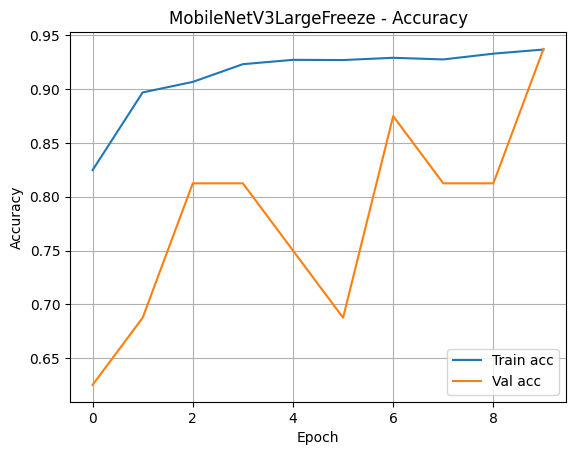

In [10]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("MobileNetV3LargeFreeze - Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("graph/accuracy.png")  # Sauvegarder la figure
mlflow.log_artifact("graph/accuracy.png")  # Enregistrer l'artefact dans MLflow
plt.show()

### Affinage du Modèle

Nous allons "défreezer" les 20 dernières couches du modèle, recompiler le modèle avec un taux d'apprentissage réduit, et enregistrer les paramètres d'entraînement. Voici les étapes détaillées :

1. **"Défreezing" des 20 dernières couches** :
   Nous modifions les propriétés des 20 dernières couches du modèle de base pour les rendre entraînables. Cela permet d'affiner ces couches lors de l'entraînement, ce qui peut améliorer les performances du modèle sur notre jeu de données spécifique.

2. **Recompilation du modèle** :
   Nous recompilons le modèle avec un taux d'apprentissage réduit. Cela permet d'effectuer des ajustements plus fins des poids des couches dégelées sans provoquer de grandes variations dans les poids.

3. **Mise en place d'un nouvel Early Stopping** :
   Nous définissons une nouvelle instance d'early stopping avec une patience de 3 epochs. Cela signifie que l'entraînement s'arrêtera si la performance du modèle ne s'améliore pas pendant 3 epochs consécutives, et les meilleurs poids seront restaurés.

4. **Enregistrement des paramètres** :
   Nous enregistrons divers paramètres liés à la phase de dégel du modèle, y compris :
   - La phase d'entraînement (unfreeze).
   - Le nombre d'époques pour l'entraînement (10).
   - La taille des lots (32).
   - L'optimiseur utilisé (Adam).
   - La fonction de perte (binary_crossentropy).
   - Le taux d'apprentissage spécifique (0.00001).
   - Le nombre de couches entraînables dans le modèle.

5. **Entraînement du modèle** :
   Nous entraînons le modèle en utilisant le générateur d'entraînement, en spécifiant le nombre d'étapes par époque, les données de validation, le nombre d'époques, les poids de classe pour gérer le déséquilibre des classes, et les rappels pour éviter le surapprentissage.

6. **Évaluation du modèle** :
   Après l'entraînement, nous évaluons le modèle sur l'ensemble de test pour obtenir la perte et la précision. Nous enregistrons également ces métriques pour un suivi ultérieur.


In [11]:
# Défreezer les 20 dernières couches du modèle 
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompiler avec un learning rate plus petit
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Nouveau early stopping
early_stop_fine = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
# Enregistrer les paramètres
mlflow.log_param("phase_2", "unfreeze")
mlflow.log_param("unfreeze_epochs", 10)
mlflow.log_param("unfreeze_batch_size", 32)
mlflow.log_param("unfreeze_optimizer", "adam")
mlflow.log_param("unfreeze_loss", "binary_crossentropy")
mlflow.log_param("unfreeze_learning_rate", 0.00001)  # Si vous utilisez un learning rate spécifique
mlflow.log_param("unfreeze_trainable_layers", sum([layer.trainable for layer in model.layers]))

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_valid) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop_fine]
)

# Évaluation
fine_tuned_loss, fine_tuned_acc = model.evaluate(test_generator, steps=len(X_test) // 32)
mlflow.log_metric("fine_tuned_accuracy", fine_tuned_acc)
mlflow.log_metric("fine_tuned_loss", fine_tuned_loss)
print(f"Test accuracy: {fine_tuned_acc*100:.2f}%")
print(f"Pertes : {loss}")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 872ms/step - accuracy: 0.9236 - loss: 0.2638 - val_accuracy: 0.8125 - val_loss: 0.2363
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 886ms/step - accuracy: 0.9293 - loss: 0.1904 - val_accuracy: 0.8750 - val_loss: 0.2684
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 745ms/step - accuracy: 0.9322 - loss: 0.1642 - val_accuracy: 0.9375 - val_loss: 0.1559
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 811ms/step - accuracy: 0.9353 - loss: 0.1525 - val_accuracy: 0.8125 - val_loss: 0.2189
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 838ms/step - accuracy: 0.9359 - loss: 0.1500 - val_accuracy: 0.9375 - val_loss: 0.2463
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 781ms/step - accuracy: 0.9411 - loss: 0.1417 - val_accuracy: 0.9375 - val_loss: 0.2290
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 668ms/step - accuracy: 0.7929 - loss: 0.5572
Test accuracy: 87.99%
Pertes : 0.32441607117652893


## Visualisation de l'Accuracy lors du Fine-tuning

Dans cette section, nous traçons l'accuracy du modèle MobileNetV3LargeUnFreeze au cours des époques d'entraînement.

- **Train acc** : Représente l'accuracy sur les données d'entraînement.
- **Val acc** : Représente l'accuracy sur les données de validation.

### Détails du graphique : 
- **Axe des X** : Époques
- **Axe des Y** : Accuracy
- **Titre** : MobileNetV3LargeUnFreeze - Accuracy

Le graphique est sauvegardé en tant qu'image et cette image est également enregistré comme artefact dans MLflow.

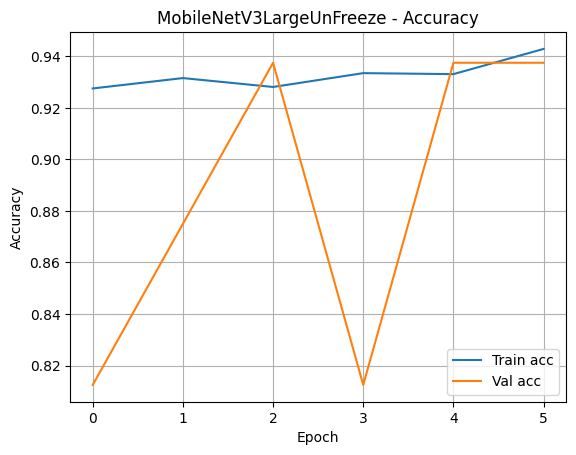

In [13]:
plt.plot(history_finetune.history['accuracy'], label='Train acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("MobileNetV3LargeUnFreeze - Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("graph/finetune_accuracy.png")  # Sauvegarder la figure
mlflow.log_artifact("graph/finetune_accuracy.png")  # Enregistrer l'artefact dans MLflow
plt.show()

### Prédictions et Évaluation du Modèle

Dans cette section, nous allons effectuer des prédictions sur l'ensemble de test et évaluer les performances du modèle. Voici les étapes détaillées :

1. **Prédictions probabilistes** :
   Nous commençons par obtenir les étiquettes réelles et les probabilités prédites par le modèle. Les sorties du modèle sont des probabilités obtenues par la fonction sigmoïde, que nous convertissons en classes binaires en utilisant un seuil de 0.5.

2. **Calcul des métriques de performance** :
   Nous calculons plusieurs métriques pour évaluer la performance du modèle, notamment :
   - **Accuracy** : Taux de précision des prédictions.
   - **Precision** : Précision des prédictions positives.
   - **Recall** : Rappel des prédictions positives.
   - **F1 Score** : Moyenne harmonique de la précision et du rappel.
   - **ROC AUC** : Aire sous la courbe ROC.
   - **Average Precision** : Précision moyenne.
   - **Log Loss** : Perte logarithmique.

   Ces métriques sont ensuite enregistrées dans MLflow pour un suivi ultérieur.

3. **Obtention des classes réelles** :
   Nous extrayons les classes réelles à partir du générateur de test pour les utiliser dans l'évaluation.

4. **Calcul de la matrice de confusion** :
   Nous calculons la matrice de confusion pour visualiser les performances du modèle sur les classes prédites par rapport aux classes réelles. Cela nous permet de voir combien de prédictions étaient correctes et incorrectes pour chaque classe.

5. **Calcul du rapport de classification** :
   Nous générons un rapport de classification qui fournit des informations détaillées sur la précision, le rappel et le F1 score pour chaque classe, ce qui nous aide à évaluer la performance du modèle de manière plus approfondie.

6. **Visualisation de la matrice de confusion** :
   Nous visualisons la matrice de confusion à l'aide d'un heatmap, ce qui nous permet de mieux comprendre les performances du modèle. La matrice est sauvegardée en tant qu'image et enregistrée dans MLflow.

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 760ms/step
Matrice de confusion :
[[173  61]
 [ 11 379]]
Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       0.94      0.74      0.83       234
   PNEUMONIA       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.86      0.87       624
weighted avg       0.89      0.88      0.88       624



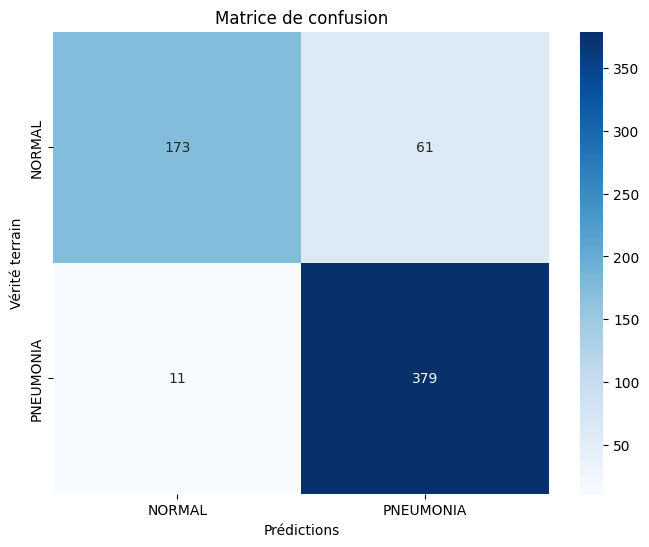

In [14]:
# Prédictions probabilistes (sorties sigmoid)
y_true = test_generator.y
y_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = (y_probs > 0.5).astype("int32") 

accuracy_score_metric=accuracy_score(y_true, y_pred)
precision_score_metric=precision_score(y_true, y_pred)
recall_score_metric=recall_score(y_true, y_pred)
f1_score_metric=f1_score(y_true, y_pred)
roc_auc_score_metric=roc_auc_score(y_true, y_probs)
average_precision_score_metric= average_precision_score(y_true, y_probs)
log_loss_metric=log_loss(y_true, y_probs)

# Calcul des métriques 
mlflow.log_metric("accuracy", round(accuracy_score_metric,3))
mlflow.log_metric("precision", round(precision_score_metric,3))
mlflow.log_metric("recall", round(recall_score_metric,3))
mlflow.log_metric("f1_score", round(f1_score_metric,3))
mlflow.log_metric("roc_auc", round(roc_auc_score_metric,3))
mlflow.log_metric("average_precision", round(average_precision_score_metric,3))
mlflow.log_metric("log_loss", round(log_loss_metric,3))

# Obtenir les classes réelles à partir du générateur
y_test = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)

# Calculer le rapport de classification
class_report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print("Rapport de classification :")
print(class_report)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.ylabel('Vérité terrain')
plt.xlabel('Prédictions')
plt.title('Matrice de confusion')
plt.savefig("graph/confuse_matrix.png")
mlflow.log_artifact("graph/confuse_matrix.png")
plt.show()

### Courbes ROC et Précision-Rappel

Dans cette section, nous allons tracer la courbe ROC et la courbe Précision-Rappel pour évaluer les performances de notre modèle. Voici les étapes détaillées :

1. **Courbe ROC** :
   Nous calculons le taux de faux positifs (FPR) et le taux de vrais positifs (TPR) à l'aide de la fonction `roc_curve`. Ensuite, nous calculons l'aire sous la courbe (AUC) pour quantifier la performance du modèle.

   Nous traçons ensuite la courbe ROC, où l'axe des abscisses représente le taux de faux positifs et l'axe des ordonnées représente le taux de vrais positifs. La courbe est accompagnée d'une ligne diagonale représentant un modèle aléatoire.

   Plus la courbe est éloigné de la ligne diagonale représentant un modèle aléatoire dans l'axe des vrais positifs, plus notre résultat sera précis . 

2. **Courbe Précision-Rappel** :
   Nous calculons la précision et le rappel à l'aide de la fonction `precision_recall_curve`. Nous calculons également la précision moyenne pour évaluer la performance globale.

   Nous traçons ensuite la courbe Précision-Rappel, où l'axe des abscisses représente le rappel et l'axe des ordonnées représente la précision. Cette courbe nous aide à comprendre le compromis entre la précision et le rappel pour différents seuils de classification.

Ces courbes nous permettent d'évaluer la performance de notre modèle en termes de compromis entre le taux de faux positifs et le taux de vrais positifs, ainsi que la précision et le rappel.


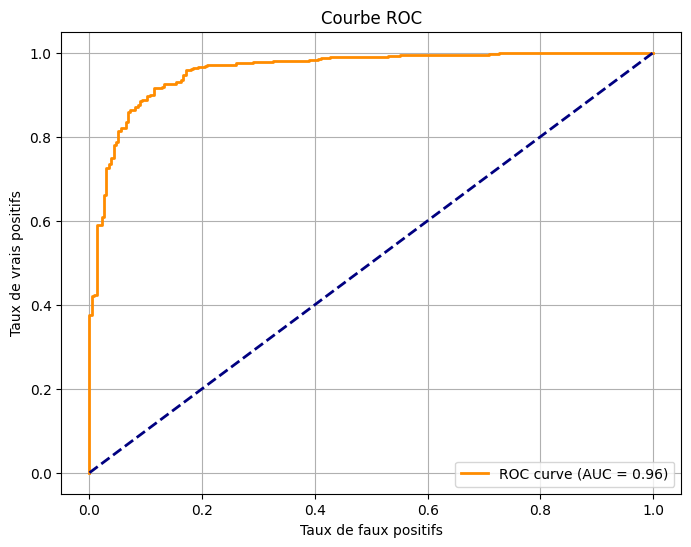

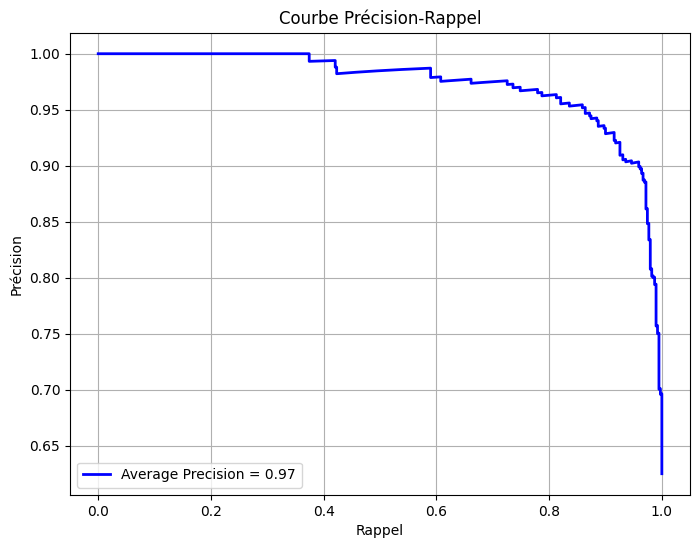

In [15]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("graph/roc_curve.png")
mlflow.log_artifact("graph/roc_curve.png")

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f"Average Precision = {avg_precision:.2f}")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig("graph/precision_recall_curve.png")
mlflow.log_artifact("graph/precision_recall_curve.png")


### Conclusion sur les résultats 

Le modèle obtient de bonnes performances sur les données de test, avec une précision globale et une matrice de confusion asez correct. Il doit rester des axes d'amélioration possibles, notamment en testant d'autres architectures, en effectuant de l'augmentation de données plus poussée ou en équilibrant davantage les classes si besoin.

### Visualisation des Prédictions

Dans cette section, nous allons visualiser les prédictions du modèle sur un lot d'images provenant du générateur de test. Voici les étapes détaillées :

1. **Obtention d'un lot d'images et d'étiquettes** :
   Nous commençons par obtenir un lot d'images et d'étiquettes à partir du générateur de test. Cela nous permet de travailler avec un ensemble d'images pour effectuer des prédictions.

2. **Mapping des classes** :
   Nous définissons un dictionnaire pour mapper les classes numériques aux étiquettes correspondantes.  `0` correspond à "Normal" et `1` correspond à "Pneumonia".

3. **Choix d'un indice aléatoire** :
   Nous choisissons un indice aléatoire dans le lot d'images pour sélectionner une image à prédire. Cela nous permet de visualiser une prédiction aléatoire à partir du lot.

4. **Prédiction** :
   Nous effectuons une prédiction sur l'image sélectionnée. Nous calculons la probabilité que l'image appartienne à la classe "Pneumonia" et déterminons la classe prédite en fonction d'un seuil de 0.5.

5. **Affichage de l'image** :
   Enfin, nous affichons l'image sélectionnée avec un titre indiquant la classe prédite et la probabilité associée. L'image est normalisée pour être lisible.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


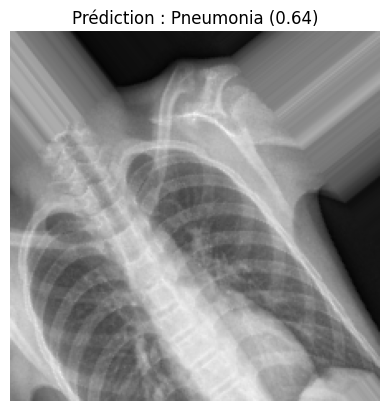

In [16]:
# Obtenir un lot d'images et d'étiquettes depuis test_generator
images, labels = next(iter(test_generator))

# Mapping des classes
label_name = {0: "Normal", 1: "Pneumonia"}

# Choisir un indice aléatoire dans le batch
i = random.randint(0, len(images) - 1)

# Prédiction
proba = model.predict(np.expand_dims(images[i], axis=0))[0][0]
predicted_class = int(proba > 0.5)

# Affichage de l’image
plt.imshow((images[i] / 255.0).astype(np.float32))  # /255 pour rendre l’image lisible
plt.title(f"Prédiction : {label_name[predicted_class]} ({proba:.2f})")
plt.axis("off")
plt.show()


# Enregistrement du Modèle avec MLflow

Dans cette section, nous allons enregistrer notre modèle Keras en utilisant MLflow:

1. **Récupération d'un mini-batch depuis le générateur** :
   Nous commençons par récupérer un mini-batch d'images à partir du générateur d'entraînement. Cela nous permet d'obtenir un ensemble d'images pour effectuer des inférences.

2. **Sélection d'un exemple d'entrée** :
   Nous sélectionnons une seule image du mini-batch pour l'utiliser comme exemple d'entrée. Cette image sera utilisée pour inférer la signature d'entrée et de sortie du modèle.

3. **Déduction de la signature d'entrée/sortie** :
   Nous déduisons automatiquement la signature d'entrée et de sortie du modèle en utilisant l'exemple d'entrée. Cela permet de définir la structure des données que le modèle attend et produit.

4. **Enregistrement du modèle** :
   Nous enregistrons le modèle Keras dans MLflow en spécifiant le chemin d'artefact et en incluant la signature inférée. Cela permet de conserver une version du modèle avec ses métadonnées.

5. **Fin de l'exécution** :
   Enfin, nous terminons l'exécution de l'enregistrement dans MLflow, ce qui permet de finaliser le suivi de cette expérience.

Cette approche nous permet de conserver une trace de notre modèle et de ses caractéristiques, facilitant ainsi la gestion des versions et le suivi des expériences.


In [17]:
# On récupère un mini-batch depuis le générateur
X_batch, _ = train_generator[0]  # train_generator[0][0] = images, [0][1] = labels
example_input = X_batch[0:1]     # On prend une seule image, format (1, H, W, 3)
# Inférer automatiquement la signature d'entrée/sortie
signature = infer_signature(example_input, model.predict(example_input))

mlflow.keras.log_model(
    model,
    artifact_path="model",
    signature=signature
)

# Terminer l'exécution
mlflow.end_run()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
🏃 View run abundant-bear-79 at: http://localhost:5000/#/experiments/335108224053349855/runs/bcd6cf853c2b4fca8229a3ac85827a3b
🧪 View experiment at: http://localhost:5000/#/experiments/335108224053349855
